# AdaBoost Experiment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Constants

In [23]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42
DATASET_SPLIT_SIZE=0.2

# Load Dataset

In [4]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID", how="left")

# Free up memory
del transactions
del identities

In [21]:
# Separate features and target values
y_total = df["isFraud"]
X_total = df.drop(columns=["isFraud"])

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=DATASET_SPLIT_SIZE, random_state=RANDOM_STATE)

# Dagshub Setup

In [7]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 53.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
 

In [8]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [9]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("AdaBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "AdaBoost")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

# Cleaning

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillNAWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._na_mapping = {}
    
    def fit(self, X, y=None):
        
        for feat in X.columns:
            median = X[feat].median()
            self._na_mapping[feat] = median
        
        return self

    def transform(self, X):
        X = X.copy()

        for feat, value in self._na_mapping.items():
            X[feat] = X[feat].fillna(value)
        
        return X

# Feature Engineering

In [12]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X.columns if X[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

# Final Pipeline

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def create_pipeline():
    # AdaBoost Forest consists of small trees called Stumps
    stump = DecisionTreeClassifier(max_depth=1)
    model = AdaBoostClassifier(
        estimator=stump,
        random_state=42
    )
    pipeline = Pipeline([
        ('woe_encoder', woe_encoder),
        ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
        ('fill_na_with_median', FillNAWithMedian()),
        ('scaler', StandardScaler()),
        ('classifier', model),
    ])
    return pipeline

# Training

In [38]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__learning_rate": [1, 1.5, 2],
    "classifier__n_estimators": [30, 50, 100],
}

In [39]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
pipeline = create_pipeline()
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [40]:
grid_search.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END classifier__learning_rate=1, classifier__n_estimators=30;, score=(train=0.864, test=0.867) total time= 1.8min
[CV 2/3] END classifier__learning_rate=1, classifier__n_estimators=30;, score=(train=0.867, test=0.860) total time= 1.7min
[CV 3/3] END classifier__learning_rate=1, classifier__n_estimators=30;, score=(train=0.867, test=0.861) total time= 1.7min
[CV 1/3] END classifier__learning_rate=1, classifier__n_estimators=50;, score=(train=0.873, test=0.876) total time= 2.6min
[CV 2/3] END classifier__learning_rate=1, classifier__n_estimators=50;, score=(train=0.878, test=0.871) total time= 2.5min
[CV 3/3] END classifier__learning_rate=1, classifier__n_estimators=50;, score=(train=0.877, test=0.869) total time= 2.6min
[CV 1/3] END classifier__learning_rate=1, classifier__n_estimators=100;, score=(train=0.884, test=0.887) total time= 4.6min
[CV 2/3] END classifier__learning_rate=1, classifier__n_estimators=100;, score

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                       ('drop_high_na_feats',
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                           random_state=42))]),
             param_grid={'classifier__learning_rate': [1, 1.5, 2],
                         'classifier__n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [41]:
grid_search.best_score_

0.8825256415014202

In [42]:
grid_search.best_params_

{'classifier__learning_rate': 1, 'classifier__n_estimators': 100}

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"adaboost_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"adaboost_roc_curve_mirrored.png")
    plt.show()

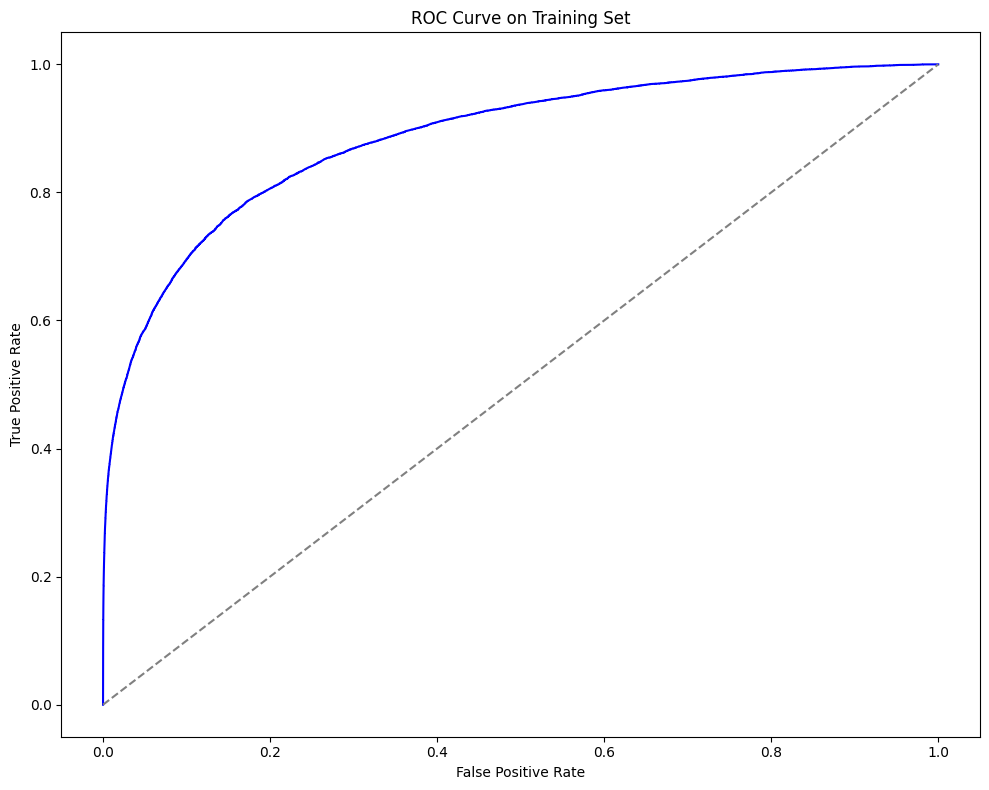

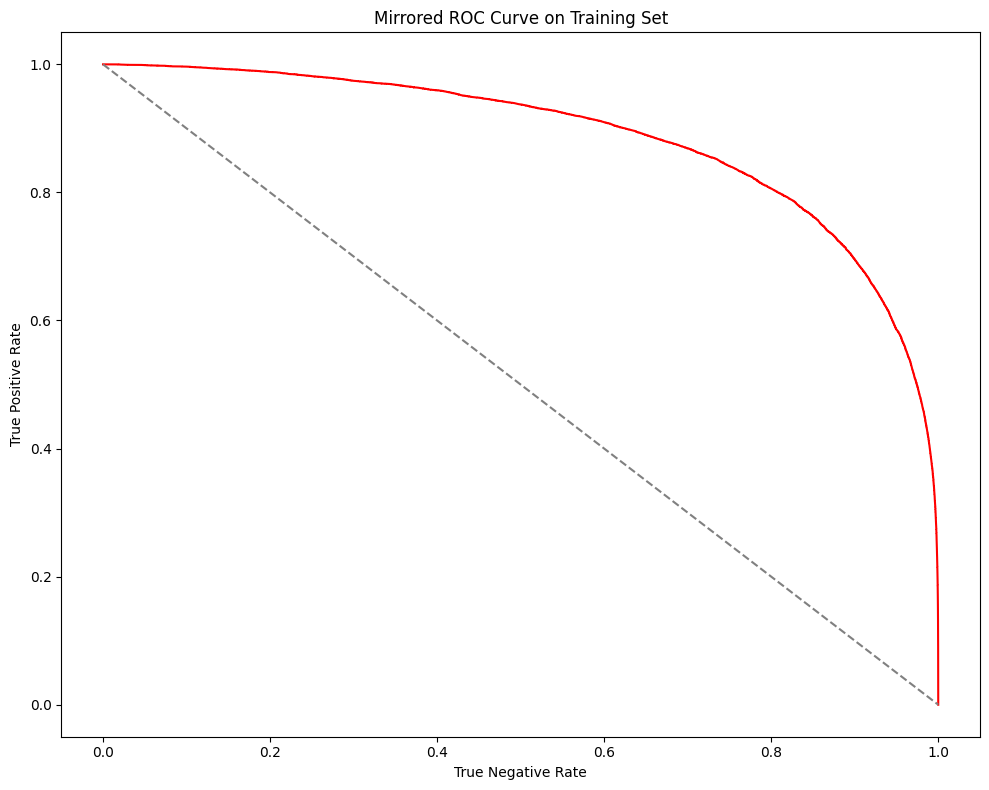

In [44]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X, y)

# Log Model

In [35]:
# https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict/

class ProbabilityModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def load_context(self, context):
        pass

    def predict(self, context, model_input, params=None):
        return self.model.predict_proba(model_input)[:, 1]

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [36]:
def log_custom_pymodel(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("AdaBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.pyfunc.log_model("AdaBoost", python_model=ProbabilityModel(best_pipeline))
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [47]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}

In [48]:
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__learning_rate': 1,
 'classifier__n_estimators': 100}

In [33]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

In [50]:
metrics = get_metrics(grid_search)

In [51]:
metrics

{'mean_fit_time': 264.1912410259247,
 'std_fit_time': 4.39836179015562,
 'mean_score_time': 13.419607162475586,
 'std_score_time': 0.115354853589604,
 'split0_test_score': 0.8865425283501026,
 'split1_test_score': 0.8811801480249737,
 'split2_test_score': 0.8798542481291842,
 'mean_test_score': 0.8825256415014202,
 'std_test_score': 0.002891486076945217,
 'split0_train_score': 0.8841966722420729,
 'split1_train_score': 0.8889865584615742,
 'split2_train_score': 0.8879820360587745,
 'mean_train_score': 0.8870550889208072,
 'std_train_score': 0.002062389511607247}

In [52]:
best_pipeline = grid_search.best_estimator_

In [53]:
log_model(
    run_name="AdaBoost_Model_1",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["adaboost_roc_curve.png", "adaboost_roc_curve_mirrored.png"]
)

2025/04/27 17:17:51 INFO mlflow.tracking.fluent: Experiment with name 'AdaBoost_Training' does not exist. Creating a new experiment.
2025/04/27 17:18:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost_Model_1 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4/runs/6b4d83babc8748f18b334a01a91d87b5
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4


In [54]:
log_custom_pymodel(
    run_name="AdaBoost_Prob_Model_1",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["adaboost_roc_curve.png", "adaboost_roc_curve_mirrored.png"]
)

2025/04/27 17:18:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost_Prob_Model_1 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4/runs/ab773553dccd4c698f2ac1cb9f10995e
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4


# Experiment 2: Imbalanced Learn

In [26]:
param_grid = {
    "classifier__learning_rate": [0.1],
    "classifier__n_estimators": [1, 3, 5],
}

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE

# AdaBoost Forest consists of small trees called Stumps
stump = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(
    estimator=stump,
    random_state=42
)
pipeline = ImbalancedPipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [29]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END classifier__learning_rate=0.1, classifier__n_estimators=1;, score=(train=0.667, test=0.661) total time=  43.0s
[CV 2/3] END classifier__learning_rate=0.1, classifier__n_estimators=1;, score=(train=0.665, test=0.664) total time=  39.7s
[CV 3/3] END classifier__learning_rate=0.1, classifier__n_estimators=1;, score=(train=0.663, test=0.669) total time=  39.9s
[CV 1/3] END classifier__learning_rate=0.1, classifier__n_estimators=3;, score=(train=0.699, test=0.693) total time= 1.0min
[CV 2/3] END classifier__learning_rate=0.1, classifier__n_estimators=3;, score=(train=0.696, test=0.694) total time= 1.0min
[CV 3/3] END classifier__learning_rate=0.1, classifier__n_estimators=3;, score=(train=0.695, test=0.702) total time= 1.0min
[CV 1/3] END classifier__learning_rate=0.1, classifier__n_estimators=5;, score=(train=0.742, test=0.740) total time= 1.4min
[CV 2/3] END classifier__learning_rate=0.1, classifier__n_estimators=5;, 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                       ('drop_high_na_feats',
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                           random_state=42))]),
             param_grid={'classifier__learning_rate': [0.1],
                         'classifier__n_estimators': [1, 3, 5]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [30]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "oversampler": "smote",
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'oversampler': 'smote',
 'kfold_n_splits': 3,
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 5}

In [31]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.7537559254431206

In [34]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 78.08718474706014,
 'std_fit_time': 0.39913610916238335,
 'mean_score_time': 3.4092957178751626,
 'std_score_time': 0.019693964402414672,
 'split0_test_score': 0.7401318314248927,
 'split1_test_score': 0.7398662986082286,
 'split2_test_score': 0.7426632009029704,
 'mean_test_score': 0.7408871103120306,
 'std_test_score': 0.001260555501779597,
 'split0_train_score': 0.7419667515342453,
 'split1_train_score': 0.7400550033305664,
 'split2_train_score': 0.7418707143781034,
 'mean_train_score': 0.7412974897476383,
 'std_train_score': 0.000879444959921195,
 'validation_score': 0.7537559254431206}

In [37]:
log_custom_pymodel(
    run_name="AdaBoost_Prob_Model_Underfit",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 09:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost_Prob_Model_Underfit at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4/runs/86a38b2baf1c4a2386d74bc1b2eba773
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4


# Experiment 2

In [39]:
param_grid = {
    "classifier__learning_rate": [0.1],
    "classifier__n_estimators": [10],
}

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE

# AdaBoost Forest consists of small trees called Stumps
stump = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(
    estimator=stump,
    random_state=42
)
pipeline = ImbalancedPipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [40]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [41]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END classifier__learning_rate=0.1, classifier__n_estimators=10;, score=(train=0.829, test=0.826) total time= 3.4min
[CV 2/3] END classifier__learning_rate=0.1, classifier__n_estimators=10;, score=(train=0.826, test=0.827) total time= 3.4min
[CV 3/3] END classifier__learning_rate=0.1, classifier__n_estimators=10;, score=(train=0.830, test=0.828) total time= 3.4min


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                       ('drop_high_na_feats',
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                           random_state=42))]),
             param_grid={'classifier__learning_rate': [0.1],
                         'classifier__n_estimators': [10]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [43]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "oversampler": "smote",
    "kfold_n_splits": KFOLD_N_SPLITS,
    "stump_max_depth": 2,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'oversampler': 'smote',
 'kfold_n_splits': 3,
 'stump_max_depth': 2,
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 10}

In [44]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8360491363277512

In [45]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 199.36586157480875,
 'std_fit_time': 0.894336663209067,
 'mean_score_time': 3.7736167907714844,
 'std_score_time': 0.037996440167127686,
 'split0_test_score': 0.8261641261204815,
 'split1_test_score': 0.8266435036596135,
 'split2_test_score': 0.8280841432251504,
 'mean_test_score': 0.8269639243350818,
 'std_test_score': 0.0008159323818005222,
 'split0_train_score': 0.8285172564554921,
 'split1_train_score': 0.8262500189302628,
 'split2_train_score': 0.8301754139736509,
 'mean_train_score': 0.8283142297864686,
 'std_train_score': 0.0016089533726235384,
 'validation_score': 0.8360491363277512}

In [46]:
log_custom_pymodel(
    run_name="AdaBoost_Prob_Model_Deeper_Stump_1",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 09:58:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost_Prob_Model_Deeper_Stump_1 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4/runs/a68eda690943451893873b18b1d5c00d
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4


# Experiment 3

In [55]:
param_grid = {
    "classifier__learning_rate": [1, 2],
    "classifier__n_estimators": [70],
}

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE

# AdaBoost Forest consists of small trees called Stumps
stump = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(
    estimator=stump,
    random_state=42
)
pipeline = ImbalancedPipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [57]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [58]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END classifier__learning_rate=1, classifier__n_estimators=70;, score=(train=0.857, test=0.856) total time=11.1min
[CV 2/3] END classifier__learning_rate=1, classifier__n_estimators=70;, score=(train=0.860, test=0.856) total time=11.2min
[CV 3/3] END classifier__learning_rate=1, classifier__n_estimators=70;, score=(train=0.858, test=0.855) total time=12.0min
[CV 1/3] END classifier__learning_rate=2, classifier__n_estimators=70;, score=(train=0.322, test=0.328) total time=11.9min
[CV 2/3] END classifier__learning_rate=2, classifier__n_estimators=70;, score=(train=0.571, test=0.577) total time=11.7min
[CV 3/3] END classifier__learning_rate=2, classifier__n_estimators=70;, score=(train=0.377, test=0.372) total time=11.8min


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                       ('drop_high_na_feats',
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                           random_state=42))]),
             param_grid={'classifier__learning_rate': [1, 2],
                         'classifier__n_estimators': [70]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [59]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "oversampler": "smote",
    "kfold_n_splits": KFOLD_N_SPLITS,
    "stump_max_depth": 2,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'oversampler': 'smote',
 'kfold_n_splits': 3,
 'stump_max_depth': 2,
 'classifier__learning_rate': 1,
 'classifier__n_estimators': 70}

In [62]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8604829112390502

In [63]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 677.9592864513397,
 'std_fit_time': 23.540672609711496,
 'mean_score_time': 8.577726284662882,
 'std_score_time': 0.2943843829844051,
 'split0_test_score': 0.8559962755821178,
 'split1_test_score': 0.8559306325148732,
 'split2_test_score': 0.855412234534888,
 'mean_test_score': 0.8557797142106264,
 'std_test_score': 0.0002612256203997791,
 'split0_train_score': 0.8569963916224062,
 'split1_train_score': 0.8595435536832672,
 'split2_train_score': 0.8584473782207829,
 'mean_train_score': 0.8583291078421521,
 'std_train_score': 0.0010432320141172044,
 'validation_score': 0.8604829112390502}

In [64]:
best_pipeline = grid_search.best_estimator_
log_custom_pymodel(
    run_name="AdaBoost_Prob_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 12:11:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run AdaBoost_Prob_Model_2 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4/runs/1e10a425b3a94a01bfa29c90009827f1
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/4
